# Wnioskowanie statystyczne

Jednym z elementów analizy danych jest opisanie uzyskanych wyników eksperymentalnych (pomiarów, obserwacji) za pomocą modelu, który pozwoliłby na przewidywanie zachowania się zjawiska czy układu w przyszłości. Pewne zjawiska można opisać analitycznie za pomocą funkcji lub równań (zwykłych, różniczkowych, całkowych); ewentualnie takie zagadnienie można rozwiązać numerycznie. 

W takim przypadku mamy do czynienia ze zjawiskiem deterministycznym. Nie ogranicza nas to do mechaniki klasycznej - deterministyczne mogą być nie tylko takie parametry jak położenie, czy pęd, ale także takie jak funkcja falowa. Znając funkcję falową układu w dowolnym momencie, oraz działające siły, jesteśmy w stanie wyznaczyć stan układu w dowolnym czasie. Funkcja falowa przekłada się oczywiście na wszelkie inne informacje np. prawdopodobieństwo znalezienia cząstki w danym stanie.

Są jednak zagadnienia, które z natury mają charakter statystyczny. W niektórych przypadkach nie umiemy opisać rzeczywistości i wyprowadzić rozkładu statytycznego z bardziej pierwotnych zasad. Czasami świadomie wybieramy fenemenologiczną drogę, ponieważ rozwiązanie problemu jest zbyt czasochłonne lub nie jest potrzebne. W przypadku fenemenologicznego opisu bazujemy na obserwacjach, na ich podstawie tworzymy model (np. opisując statystyczny rozkład jakiegoś parametru funkcją). W przypadku tego podejścia nie wiemy do końca jaki powinien być rozkład (czasami możemy mieć pewne przesłanki, ograniczenia itp.), więc jego wyboru musimy dokonać na podstawie wnioskowania statystycznego poprzez porównanie zaproponowanych modeli.


Spróbujmy wygenerować dane ze znanego nam rozkładu, a potem porównać wyniki dopasowania różnych rozkładów i na tej podstawie dokonać wyboru modelu.

W Julii biblioteka [Distributions](https://juliastats.org/Distributions.jl/stable/) zawiera bardzo bogatą kolekcję rozkładów prawdopodobieństwa i związanych z nimi narzędzi.

In [1]:
using Distributions
using Random
using StatsBase
using GRUtils

Random.seed!(1501)
data = rand(Gamma(10.0, 2.0), 500)

500-element Vector{Float64}:
 19.654730714163545
 24.930693743817383
 15.811401321858323
 19.45362983534311
 16.39183380965854
 19.105317397233282
 11.027306175709624
 26.493160836152338
 20.47428365258174
 14.811515221246317
 15.022764892808445
 28.56326311204799
 28.189629664865908
  ⋮
 16.39399883118123
 25.642740171587086
 16.674798544857246
 19.636238834843006
 25.989044852263866
 16.137351394452214
 26.106660547853107
 23.176522241248456
 33.96431249544465
 25.05470902168856
 31.21411274852832
 19.02964020287115

Zanim przejdziemy do opisywania wyników rozkładami, powinniśmy utworzyć z nich funkcję gęstości prawdopodobieństwa. Nasze histogramy do tej pory zawierały liczbę zliczeń w danym przedziale, zmieniając szerokość przedziału binowania zmieniamy kształt krzywej.


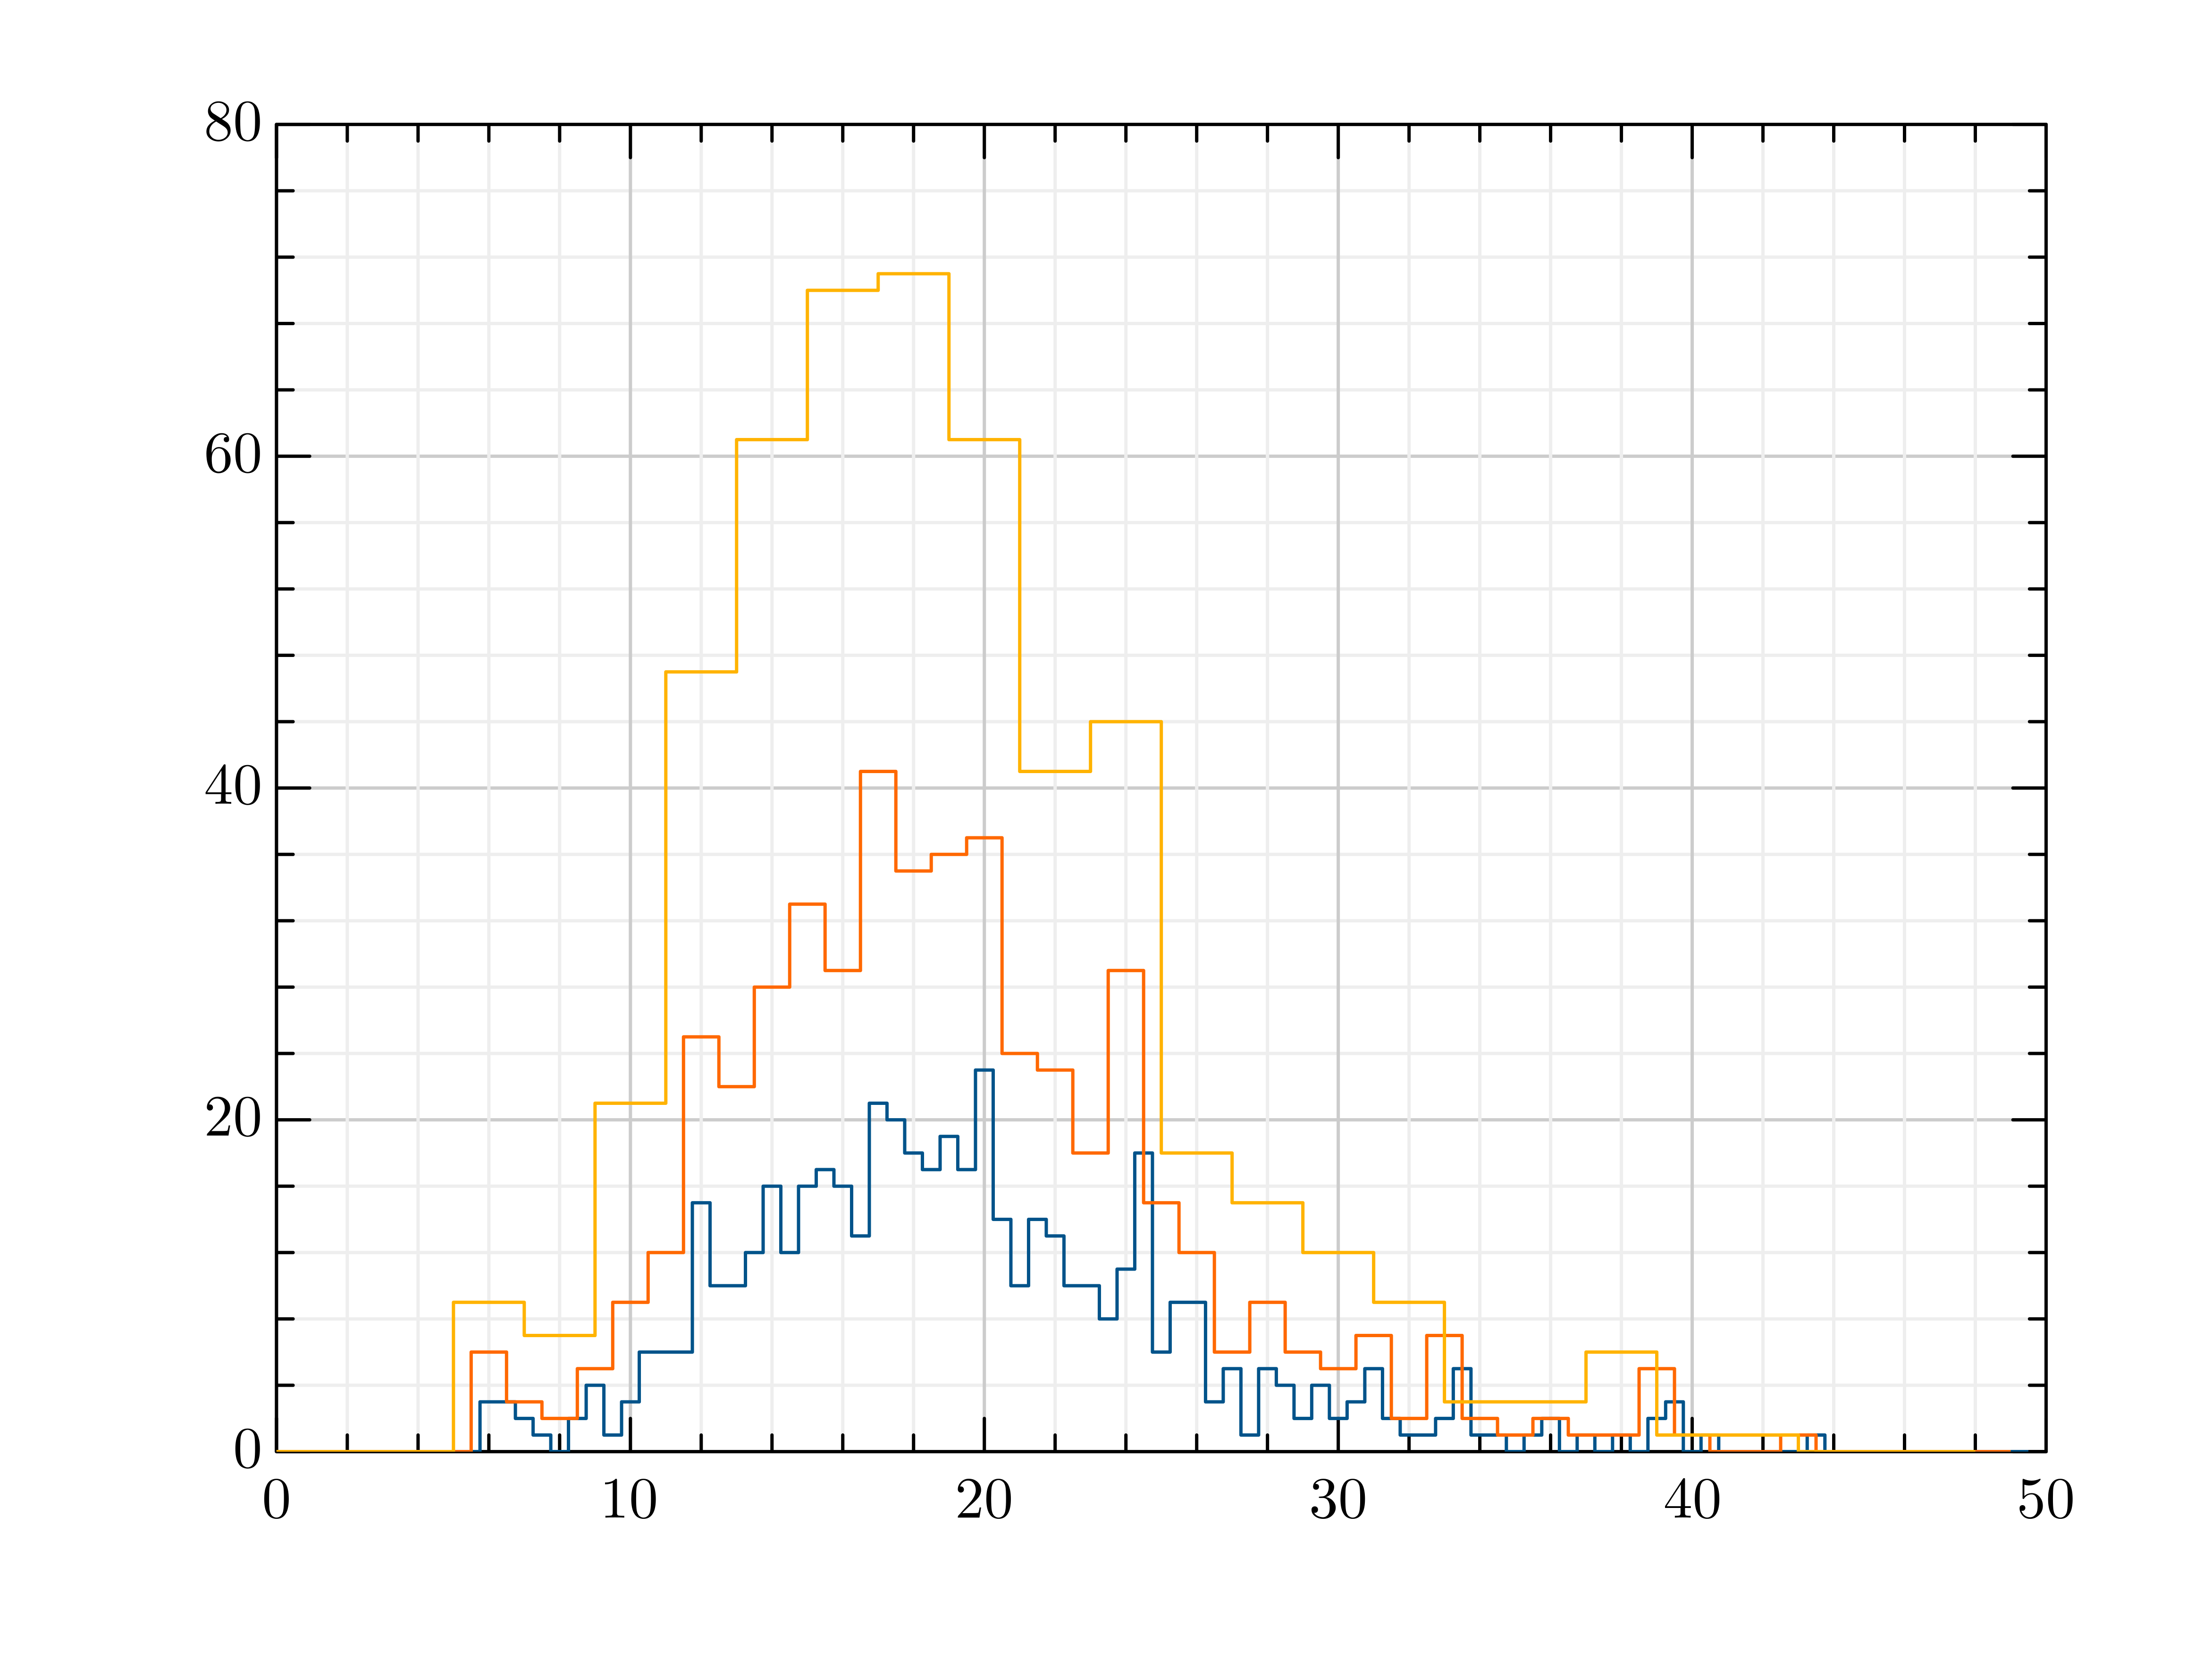

In [2]:
Figure((800, 600), "pix")
h1 = fit(Histogram, data, 0:0.5:50)
stairs(h1.edges[1][1:end-1], h1.weights)
hold(true)

h2 = fit(Histogram, data, 0:1:50)
stairs(h2.edges[1][1:end-1], h2.weights)

h3 = fit(Histogram, data, 0:2:50)
stairs(h3.edges[1][1:end-1], h3.weights)

Aby temu zapobiec musimy stworzyć rozkład gęstości: podzielić każdy bin przez sumę zdarzeń oraz przez szerokość binu. W naszym przypadku wszystkie są tej samej szerokości więc łatwo zrobić tę operację ręcznie. W bardziej ogólnym przydku gdy biny mogą mieć różną szerokość można użyć funkcji `normalize` z biblioteki LinearAlgebra

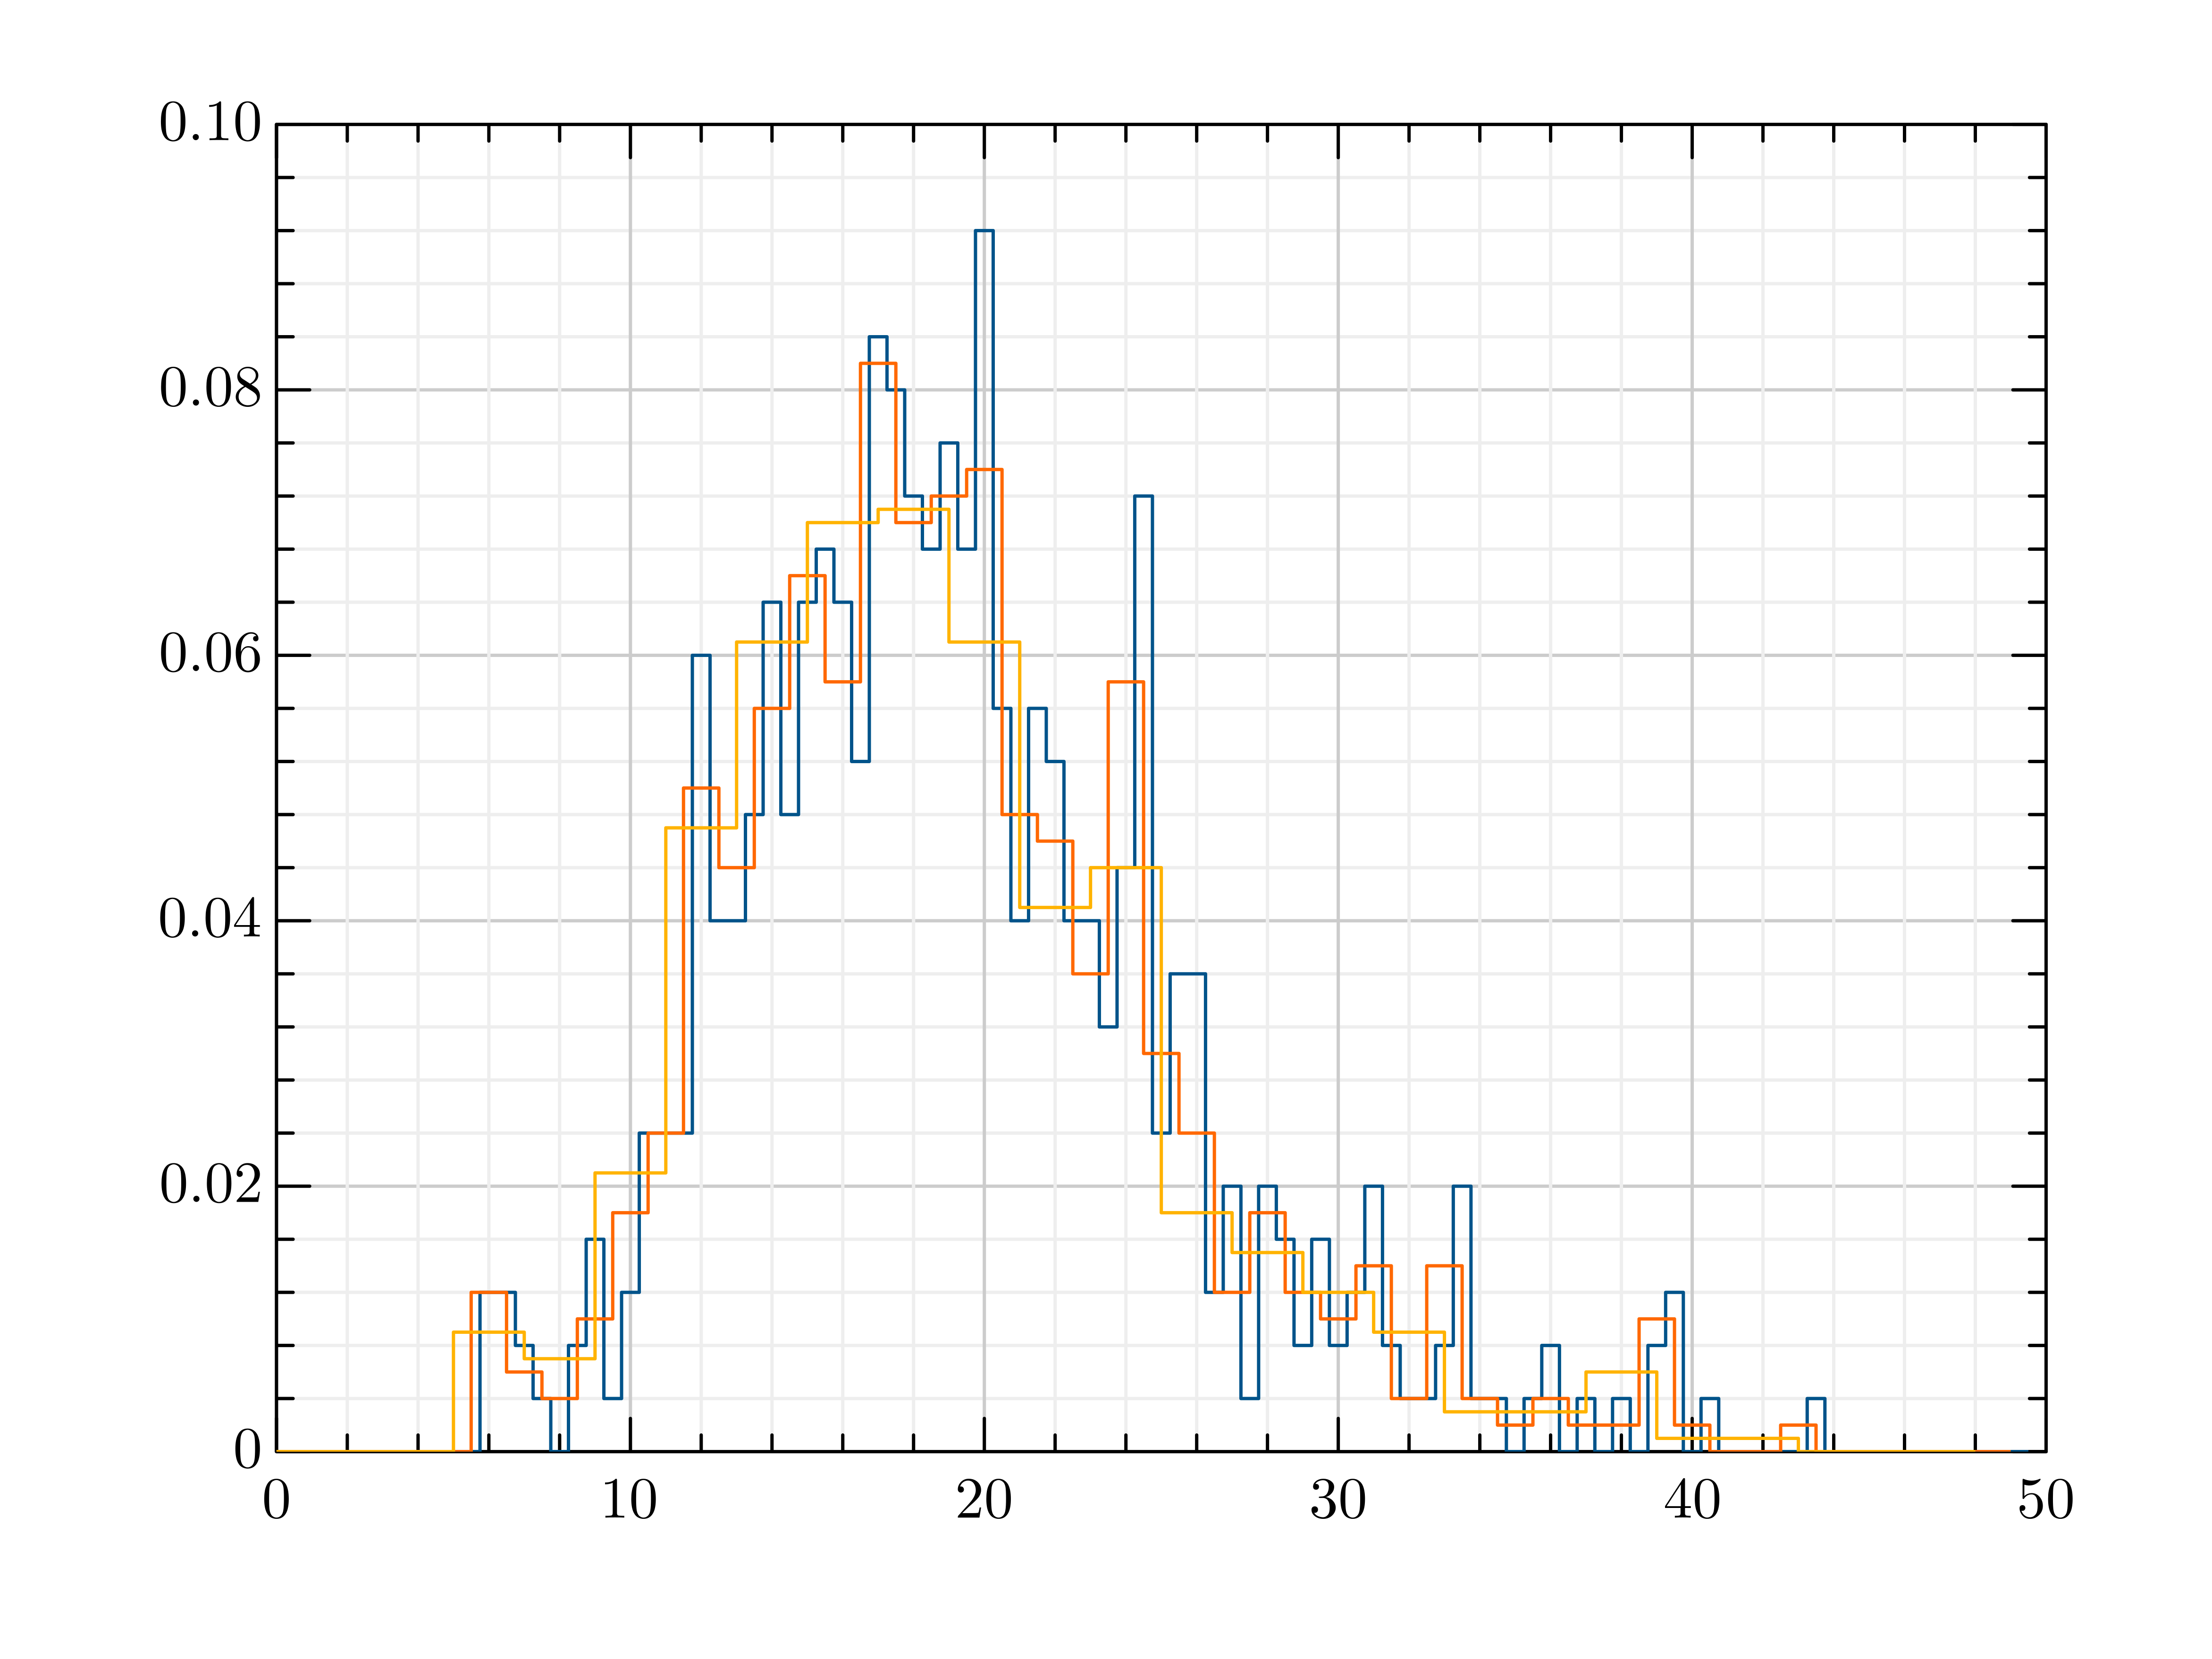

In [3]:
using LinearAlgebra

hold(false)
h1 = fit(Histogram, data, 0:0.5:50)
h1 = normalize(h1, mode=:pdf)
stairs(h1.edges[1][1:end-1], h1.weights)
hold(true)
h2 = fit(Histogram, data, 0:1:50)
h2 = normalize(h2, mode=:pdf)
stairs(h2.edges[1][1:end-1], h2.weights)
h3 = fit(Histogram, data, 0:2:50)
h3 = normalize(h3, mode=:pdf)
stairs(h3.edges[1][1:end-1], h3.weights)

Tak przygotowane dane możemy porównywać z funkcjami `pdf`. Zaczniemy od dopasowania metodą najmniejszych kwadratów. Spróbujemy opisać dane za pomocą rozkładu normalnego, gamma i Cauchy'ego 

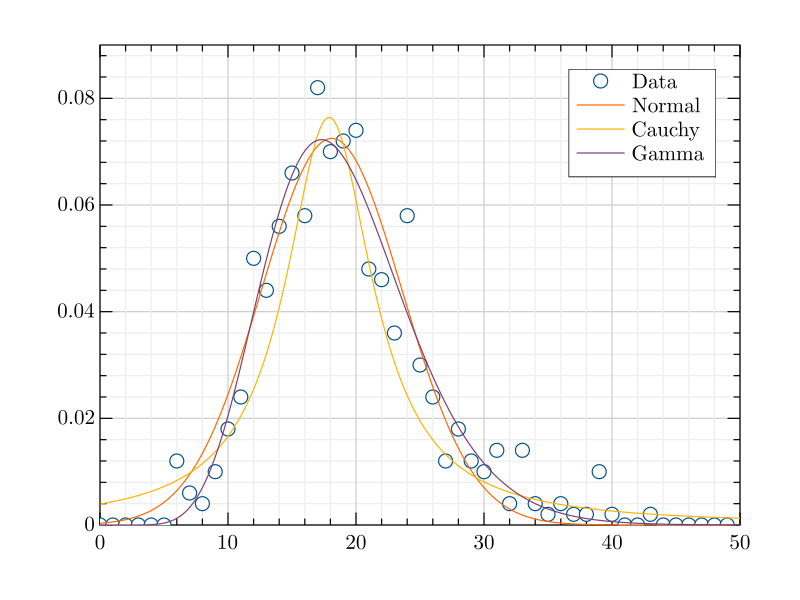

In [4]:
using LsqFit

Figure((800, 600), "pix")
h = fit(Histogram, data, 0:1:50)
hn = normalize(h, mode=:pdf)
plot(hn.edges[1][1:end-1], hn.weights, "o")
hold(true)

n(x, p) = pdf.(Normal(p...), x)
c(x, p) = pdf.(Cauchy(p...), x)
g(x, p) = pdf.(Gamma(p...), x)

fn = curve_fit(n, hn.edges[1][1:end-1], hn.weights, [10.0, 1.0])
xf = 0:0.1:50
plot(xf, n(xf, fn.param), "-")

fc = curve_fit(c, hn.edges[1][1:end-1], hn.weights, [10.0, 1.0])
plot(xf, c(xf, fc.param), "-")

fg = curve_fit(g, hn.edges[1][1:end-1], hn.weights, [10.0, 1.0])
plot(xf, g(xf, fg.param), "-")

legend("Data", "Normal", "Cauchy", "Gamma")
hold(false)
display(gcf())

Jak wybrać najlepszy model? W fizyce często automatycznie (i bez zastanowienia) posługujemy się testem Chi-kwadrat. Ten test można znaleźć w bibliotece `HypothesisTests`. Ze względu na jego konstrukcję można go stosować gdy porównujemy liczbę obserwowanych przypadków w pewnych kategoriach z modelem przewidującym prawdopodobieństwo ich zajścia. 

Wykonując test porównamy liczby zliczeń dla komórek histogramu (uwaga - nie gęstość prawdopodobieństwa!), z gęstością wyznaczoną w modelach. Ta ostatnia wielkość powinna sumować się do jedności, ale ze względu na dyskretne przedziały, ucięcia zakresu i zaokrąglenia nie jest to koniecznie prawdą. Dlatego musimy znormalizować ten parametr.

In [5]:
using HypothesisTests
using Printf

h = fit(Histogram, data, 0:1:50)

chin = ChisqTest(h.weights, normalize(n(h.edges[1][1:end-1].+0.5, fn.param), 1));
chic = ChisqTest(h.weights, normalize(c(h.edges[1][1:end-1].+0.5, fc.param), 1));
chig = ChisqTest(h.weights, normalize(g(h.edges[1][1:end-1].+0.5, fg.param), 1));

println(chic)
println("Χ² (normal) = ", @sprintf("%.2f", chin.stat))
println("Χ² (Cauchy) = ", @sprintf("%.2f", chic.stat))
println("Χ² (gamma) = ", @sprintf("%.2f", chig.stat))


Pearson's Chi-square Test
-------------------------
Population details:
    parameter of interest:   Multinomial Probabilities
    value under h_0:         [0.00467655, 0.00522882, 0.00588237, 0.00666275, 0.00760377, 0.00875073, 0.0101651, 0.0119315, 0.0141674, 0.0170374, 0.0207724, 0.0256909, 0.0322116, 0.0408132, 0.0518245, 0.0648225, 0.0775526, 0.0854772, 0.0844563, 0.0750824, 0.0619816, 0.0492957, 0.0387979, 0.0306746, 0.0245322, 0.0198957, 0.0163671, 0.0136479, 0.0115232, 0.00983982, 0.00848814, 0.00738924, 0.00648554, 0.00573449, 0.00510427, 0.00457076, 0.00411545, 0.003724, 0.00338516, 0.00309003, 0.00283147, 0.00260374, 0.00240218, 0.00222296, 0.00206292, 0.00191943, 0.00179032, 0.00167372, 0.00156809, 0.0014721]
    point estimate:          [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.012, 0.006, 0.004, 0.01, 0.018, 0.024, 0.05, 0.044, 0.056, 0.066, 0.058, 0.082, 0.07, 0.072, 0.074, 0.048, 0.046, 0.036, 0.058, 0.03, 0.024, 0.012, 0.018, 0.012, 0.01, 0.014, 0.004, 0.014, 0.004, 0.002, 0.00

 Dopasowywanie metodą najmniejszych kwadratów i test $\chi^2$ to oczywiście nie jedyna metoda wyboru modelu. 
 
 Inną techniką wyboru parametrów rozkładu jest metoda największej wiarygodności, która polega na maksymalizacji funkcji wiarygodności - w pojedynczym przypadku obserwacji danej próby, dla wielu prób będzie to iloczyn prawdopodobieństw (stąd często wykorzystywany jest logarytm funkcji wiarygodności).
 
Biblioteka `Distributions` posiada funkcję `fit`, która zwróci nam najbardziej prawdopodobne parametry rozkładu znalezione metodą największej wiarygodności (zwykle, można wymusić stosując `fit_mle`, ale nie każdy rozkład jest zaimplementowany w procedurze maksymalizacji).

In [6]:
pn = params(fit_mle(Normal, data))
pc = params(fit(Cauchy, data))
pg = params(fit_mle(Gamma, data))

(9.860219687280813, 2.000083048358065)

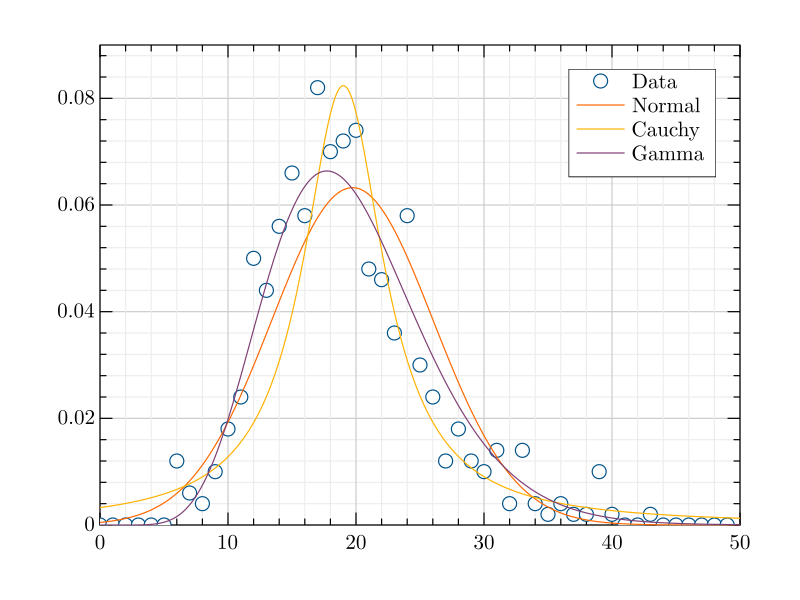

Χ² (normal) = 197.19
Χ² (Cauchy) = 91.62
Χ² (gamma) = 74.63


In [7]:
plot(hn.edges[1][1:end-1], hn.weights, "o")
hold(true)

xf = 0:0.1:50
plot(xf, n(xf, pn), "-")
plot(xf, c(xf, pc), "-")
plot(xf, g(xf, pg), "-")

legend("Data", "Normal", "Cauchy", "Gamma")
hold(false)
display(gcf())

chin = ChisqTest(h.weights, normalize(n(h.edges[1][1:end-1].+0.5, pn), 1));
chic = ChisqTest(h.weights, normalize(c(h.edges[1][1:end-1].+0.5, pc), 1));
chig = ChisqTest(h.weights, normalize(g(h.edges[1][1:end-1].+0.5, pg), 1));

println("Χ² (normal) = ", @sprintf("%.2f", chin.stat))
println("Χ² (Cauchy) = ", @sprintf("%.2f", chic.stat))
println("Χ² (gamma) = ", @sprintf("%.2f", chig.stat))


Inną ciekawą obserwacją jest fakt, że metoda najmniejszych kwadratów nie minimalizuje $\chi^2$ i wynik z metody największej wiarygodności jest inny (szczególnie dla rozkładu normalnego). Korzystając z kryterium $\chi^2$ moglibyśmy wybrać model Cauchy'ego jako najlepszy w tym przypadku, a Gamma jest zdecydowanie najgorszy.

Zanim przejdziemy do innej metody wyboru modelu, narysujemy jak wygląda funkcja wiarygodności dla badanych rozkładów. Wygodny do stosowania jest logarytm tej funkcji. Dla dowolnego rozkładu można ją policzyć w następujący sposób

In [8]:
function llike(dist, x, pars)
    ll = 0
    for xi in x
        ll += logpdf(dist(pars...), xi)
    end
    if ll == Inf || ll == -Inf
        return prevfloat(typemax(Float64))
    end
    return -ll
end

llike (generic function with 1 method)

Funkcja `logpdf` liczy logarytm rozkładu gęstości prawdopodobieństwa. Jeżeli wartość funkcji wyjdzie nam Inf (na przykład dla pdf = 0), to zamieniamy ją na najbliższą liczbę Float64 (czyli bardzo dużą). Wreszcie zwracamy minus wartość ponieważ zwykle procedury znajdują minimum, a nie maksimum.

Wykorzystamy tę funkcję do stworzenia mapy wartości wiarygodności.

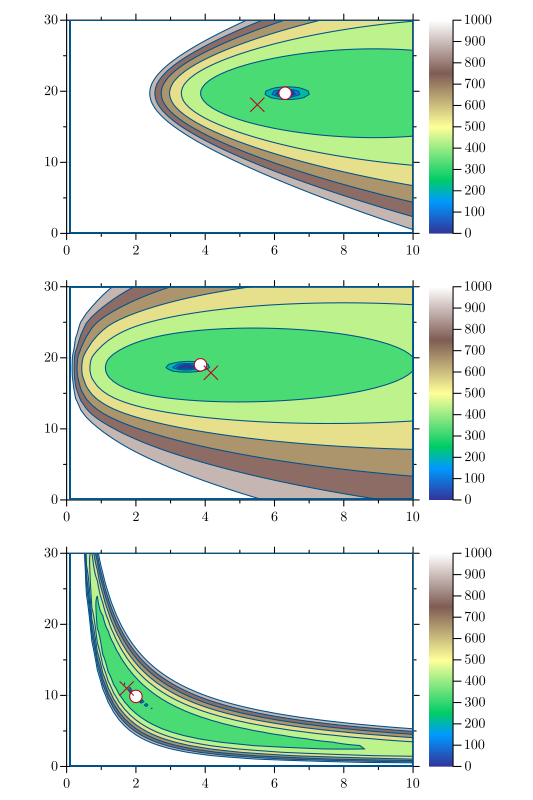

In [9]:
m = LinRange(0.1, 30, 64) |> collect
s = LinRange(0.1, 10, 64) |> collect
yn = zeros(size(m)[1], size(s)[1])
yc = zeros(size(m)[1], size(s)[1])
yg = zeros(size(m)[1], size(s)[1])

for j in 1:size(s)[1]
    for i in 1:size(m)[1]
        yn[i, j] = llike(Normal, data, [m[i], s[j]])
        yc[i, j] = llike(Cauchy, data, [m[i], s[j]])
        yg[i, j] = llike(Gamma, data, [m[i], s[j]])
    end
end

yn = yn .- minimum(yn)
yc = yc .- minimum(yc)
yg = yg .- minimum(yg)

z = [0; 1; 2; LinRange(5, 1000, 7)]
colormap("terrain")

Figure((800, 1200), "pix")
subplot(3, 1, 1)
contourf(s, m, yn, z)
oplot([pn[2]], [pn[1]], "ro")
oplot([fn.param[2]], [fn.param[1]], "rx")

subplot(3, 1, 2)
contourf(s, m, yc, z)
oplot([pc[2]], [pc[1]], "ro")
oplot([fc.param[2]], [fc.param[1]], "rx")

subplot(3, 1, 3)
contourf(s, m, yg, z)
oplot([pg[2]], [pg[1]], "ro")
oplot([fg.param[2]], [fg.param[1]], "rx")

display(gcf())


W przedstawionym zakresie każdy rozkład posiada wyraźne minimum. Miejsce gdzie różnica między minimum wynosi 1 (pierwsza poziomica), pozwala na wyznaczenie niepewności danego parametru. W przypadku rozkładu normalnego i Cauchy nie widać między parametrami korelacji, więc mamy poziome elipsy. Dla rozkładu gamma parametry są silnie skorelowane i minimum tworzy długi wąski wąwóz.

Problem wyboru modelu jest jednym z najtrudniejszych zagadnień statystyki. W latach 70-tych Hir.. Akaike sformuował powszechnie obecnie stosowane kryterium oparte o teorię informacji. Każdy model jest tylko przybliżeniem i pewne informacje zostaną w nim utracone. Miara tego ile informacji została stracona może być wykorzystana do wyboru modelu: ten, który zachowa jej najwięcej zostanie wybrany jako najlepszy. Wzór jest następujący
$$
AIC = 2k - 2\ln\hat{L}
$$
gdzie $k$ to liczba parametrów modelu, a $\hat{L}$ to maksimum funkcji wiarygodności.

Kryterium ma jedynie sens porównywania względnego modeli. Wielkość
$$
exp\left((AIC_{min} - AIC_i) / 2\right)
$$
określa prawdopodobieństwo, że model $i$ zminimalizuje utratę informacji w porównaniu do najlepszego modelu.

W naszym przypadku $2k = 4$ dla wszystkich modeli, a funkcja `llike` zwraca wynik ze znakiem minus, więc porównujemy następujące wyrażenia

In [10]:
aic_n = 4 + 2 * llike(Normal, data, pn)
aic_c = 4 + 2 * llike(Cauchy, data, pc)
aic_g = 4 + 2 * llike(Gamma, data, pg)

bestaic = min(aic_n, aic_c, aic_g)
println("ΔAIC Normal = ", aic_n - bestaic)
println("ΔAIC Cauchy = ", aic_c - bestaic)
println("ΔAIC Gamma = ", aic_g - bestaic)

ΔAIC Normal = 38.9604815762018
ΔAIC Cauchy = 157.6906274565904
ΔAIC Gamma = 0.0


In [11]:
@printf("P cauchy %.3e \n", exp((aic_g - aic_c) / 2))
@printf("P normal %.3e \n", exp((aic_n - aic_c) / 2))

P cauchy 5.727e-35 
P normal 1.652e-26 


Nie mamy wątpliwości, że kryterium AIC wskazuje na model Gamma! 

Oczywiście wyniki będą zależeć od danej próby i od jej rozmiaru. Możemy zbadać skuteczność metody wyboru modelu opartą o chi-kwadrat oraz o AIC dla wielu próbek i sprawdzić jak skuteczność ($\varepsilon$) zależy od ich rozmiaru ($N$).

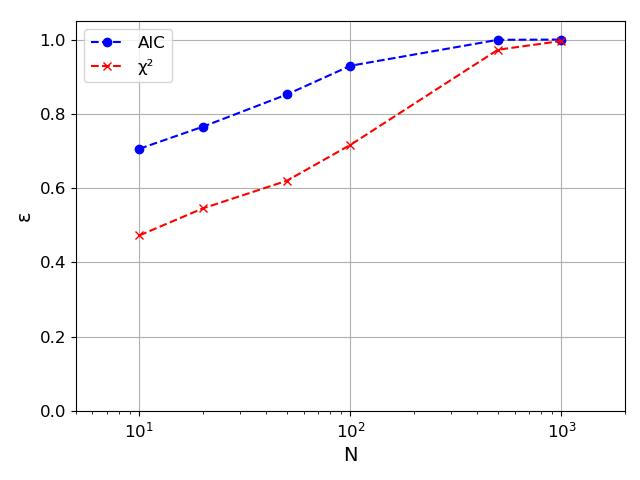

Jeżeli przyjrzymy się dokładniej źródle problemów z metodą opartą o dopasowanie, okaże się, że problem powstaje jeżeli mamy zdarzenia w ogonie rozkładu. Metoda oparta o najmniejsze kwadraty jest mało czuła na takie przypadki, ponieważ jest ich zawsze niewiele. W wartościach bezwzględnych różnica jest mała i bardziej "opłaca" się dobrać parametry rozkładu do najbardziej prawdopodobnych wartości. Tymczasem w metodzie MLE mało prawdopodobne zdarzenia z ogona może mieć duże znaczenie dla parametrów, bo przy ich innym doborze prawdopodobieństwo jego zajścia gwałtownie (eksponencjalnie) maleje i "opłaca" się tak dobrać parametry by zachować sensowne prawdopodobieństwo ich pojawienia się. 

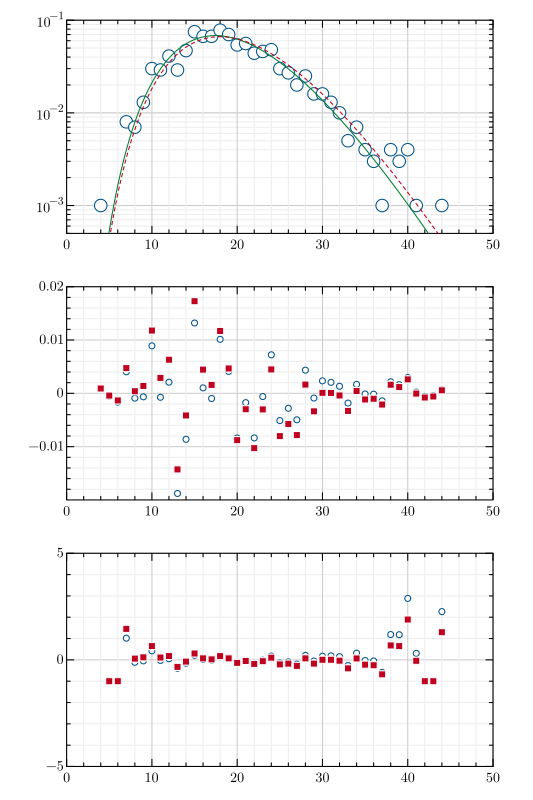

In [12]:
Random.seed!(103)
data = rand(Gamma(10.0, 2.0), 1000)

Figure((800, 1200), "pix")
h = fit(Histogram, data, nbins=50)
hn = normalize(h, mode=:pdf)

subplot(3, 1, 1)
plot(hn.edges[1][1:end-1], hn.weights, "o")
hold(true)

xf = h.edges[1][1]:0.1:h.edges[1][end]
println()
fg = curve_fit(g, hn.edges[1][1:end-1], hn.weights, [10.0, 1.0])
plot(xf, g(xf, fg.param), "g-")

pg = params(fit_mle(Gamma, data))
plot(xf, g(xf, pg), "r--")

ylog(true)
ylim(5e-4, 1e-1)

subplot(3, 1, 2)
plot(hn.edges[1][1:end-1], hn.weights - g(hn.edges[1][1:end-1], fg.param), "bo", markersize=0.5)
hold(true)
plot(hn.edges[1][1:end-1], hn.weights - g(hn.edges[1][1:end-1], pg), "rs", markersize=0.5)
ylim(-0.02, 0.02)

subplot(3, 1, 3)
plot(hn.edges[1][1:end-1], (hn.weights - g(hn.edges[1][1:end-1], fg.param)) ./ g(hn.edges[1][1:end-1], fg.param), "bo", markersize=0.5)
hold(true)
plot(hn.edges[1][1:end-1], (hn.weights - g(hn.edges[1][1:end-1], pg)) ./ g(hn.edges[1][1:end-1], pg), "rs", markersize=0.5)
ylim(-5, 5)

display(gcf())


## Zadanie

Korzystając z bazy NASA Power przeanalizować rozkład prędkości wiatru na wysokości 10 m. Dane powinny dotyczyć co najmniej 10 lat.

Z biblioteki [Distributions](https://juliastats.org/Distributions.jl/stable/) wybrać modele, które przypominają uzyskany rozkład. Wybrać najlepszy model korzystając z kryterium Akaike i za pomocą dopasowania rozkładu.

Wyniki porównać z najczęściej stosowanymi modelami
https://www.sciencedirect.com/science/article/abs/pii/S1364032119304988

In [ ]:
using DataFrames
using CSV
df = DataFrame(CSV.File("wind.csv", header=15, delim=",", ignorerepeated=true))

Innym zagadnieniem jakie możemy napotkać to testowanie czy dane próby są ze sobą zgodne (czy pochodzą z tego samego rozkładu). Procedura jest następująca
1. Stawiamy hipotezę zerową (np. dane pochodzą z tego samego rozkładu),
2. Wybieramy test, który bazuje na jakiejś statystyce (np. test K-S wyznacza maksimum różnic dystrybuanty)
3. Ustalamy poziom istotności - np. uznajemy, że przyjmujemy, że jeżeli wyliczone prawdodobieństwo, że dane są z tego samego rozkładu jest poniżej 5% to odrzucamy hipotezę, ewentualnie narażając się na popełnienie błędu pierwszego rodzaju - odrzucenie poprawnej hipotezy. 
4. Przeprowadzamy wybrany test

W naszym przypadku, jeżeli chodzi o dane dotyczące wiatru, możemy:
* stawiamy hipotezę, że nie ma różnic pomiędzy rozkładem wiatru dla różnych pór roku
* ze względu na zmiany klimatu, czy rozkład różni się dla najwcześniejszych i najpóźniejszych lat

Biblioteka `HyptothesisTests` zawiera kolekcje testów. Jedne z najbardziej popularnych, które możemy użyc w naszej sytuacji to:
* test Kołmogorowa-Smirnowa
* test Andersona-Darlinga

Obydwa testy występują w wersjach dla jednej próby (tzn. przy teście czy dana populacja pochodzi z danego teoretycznego rozkładu) oraz dla dwóch prób (przy teście pochodzenia populacji z tego samego rozkładu, test A-D może mieć w ogólności $k$ prób).

Przetestujmy nasze hipotezy przy poziomie istotności 5%.

In [ ]:
ApproximateTwoSampleKSTest(df[in.(df.MO, Ref([12, 1, 2, 3])), :].WS2M, df[in.(df.MO, Ref([4, 5, 6, 7])), :].WS2M)


In [ ]:
ApproximateTwoSampleKSTest(df[(2000 .<= df.YEAR .<= 2003), :].WS2M, df[(2018 .<= df.YEAR .<= 2021), :].WS2M)

In [ ]:
KSampleADTest(df[in.(df.MO, Ref([12, 1, 2, 3])), :].WS2M, df[in.(df.MO, Ref([4, 5, 6, 7])), :].WS2M)

In [ ]:
KSampleADTest(df[(2000 .<= df.YEAR .<= 2003), :].WS2M, df[(2018 .<= df.YEAR .<= 2021), :].WS2M)

O ile więc nie mamy podstaw do odrzucenia hipotezy, że rozkład wiatru zmienił się w latach 2018-2021 w stosunku do 2000-2003, to oba testy zdecodywanie odrzucają hipotezę o stałości rozkładu wiatru w ramach roku. Możemy sprawdzić jak wyglądają rozkłady na histrogramach.

In [ ]:
h1 = fit(Histogram, df[in.(df.MO, Ref([12, 1, 2, 3])), :].WS2M, 0:0.1:10)
h2 = fit(Histogram, df[in.(df.MO, Ref([4, 5, 6, 7])), :].WS2M, 0:0.1:10) 
h3 = fit(Histogram, df[(2000 .<= df.YEAR .<= 2003), :].WS2M, 0:0.1:10)
h4 = fit(Histogram, df[(2018 .<= df.YEAR .<= 2021), :].WS2M, 0:0.1:10)

Figure((800, 800), "pix")
subplot(2, 1, 1)
plot(h1.edges[1][1:end-1], h1.weights, "o", markersize=0.5)
hold(true)
plot(h2.edges[1][1:end-1], h2.weights, "s", markersize=0.5)
legend("Zima", "Wiosna")

subplot(2, 1, 2)
plot(h3.edges[1][1:end-1], h3.weights, "v", markersize=0.5)
hold(true)
plot(h4.edges[1][1:end-1], h4.weights, "^", markersize=0.5)
legend("2000-2003", "2018-2021")

display(gcf())


## Zadanie

Przetestować hipotezy o:
* stałości rozkładu temperatury (porównać wybrane przedziały lat)
* stałości rozkładu wiatru dla 4 pór roku (parami)